In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.models import load_model, save_model

### Initialize Dataset

In [3]:
path = 'shakespeare.txt'

In [4]:
text = open(path, 'r').read()

In [5]:
print(text[:750])


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
    Pity the world, or else this glutton be,
    To eat the world's due, by the grave and thee.


                     2
  When forty winters shall besiege thy brow,
  And dig deep


In [6]:
vocab = sorted(set(text))

In [7]:
vocab_size = len(vocab)
vocab_size

81

### Vectorize the text

In [8]:
char_to_ind = {char:ind for ind, char in enumerate(vocab)}
char_to_ind['H']

32

In [9]:
ind_to_char = np.array(vocab)
ind_to_char[32]

'H'

### Encoding the dictionary

In [10]:
encoded_text = np.array([char_to_ind[c] for c in text])

In [11]:
encoded_text

array([ 0,  1,  1, ...,  1, 73, 61])

In [12]:
sample = text[:100]
sample

"\n                     1\n  From fairest creatures we desire increase,\n  That thereby beauty's rose mi"

In [13]:
encoded_text[:100]

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 12,  0,  1,  1, 30, 71, 68, 66,  1, 59, 54, 62,
       71, 58, 72, 73,  1, 56, 71, 58, 54, 73, 74, 71, 58, 72,  1, 76, 58,
        1, 57, 58, 72, 62, 71, 58,  1, 62, 67, 56, 71, 58, 54, 72, 58,  8,
        0,  1,  1, 44, 61, 54, 73,  1, 73, 61, 58, 71, 58, 55, 78,  1, 55,
       58, 54, 74, 73, 78,  5, 72,  1, 71, 68, 72, 58,  1, 66, 62])

### Creating batches

In [14]:
seq_len = 120

In [15]:
total_num_seq = len(text) // (seq_len+1)
total_num_seq

8665

In [16]:
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
char_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [17]:
# for item in char_dataset.take(500):
#     print(ind_to_char[item.numpy()])

In [18]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

In [19]:
def create_seq_targets(seq):
    input_txt = seq[:-1] # Hello my nam
    target_txt = seq[1:] # ello my name
    return input_txt, target_txt

In [20]:
dataset = sequences.map(create_seq_targets)

In [21]:
for input_txt, target_txt in dataset.take(1):
    print(input_txt.numpy())
    print("".join(ind_to_char[input_txt.numpy()]))
    print('\n')
    print(target_txt.numpy())
    print("".join(ind_to_char[target_txt.numpy()]))

[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0
  1  1 30 71 68 66  1 59 54 62 71 58 72 73  1 56 71 58 54 73 74 71 58 72
  1 76 58  1 57 58 72 62 71 58  1 62 67 56 71 58 54 72 58  8  0  1  1 44
 61 54 73  1 73 61 58 71 58 55 78  1 55 58 54 74 73 78  5 72  1 71 68 72
 58  1 66 62 60 61 73  1 67 58 75 58 71  1 57 62 58  8  0  1  1 26 74 73]

                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0  1
  1 30 71 68 66  1 59 54 62 71 58 72 73  1 56 71 58 54 73 74 71 58 72  1
 76 58  1 57 58 72 62 71 58  1 62 67 56 71 58 54 72 58  8  0  1  1 44 61
 54 73  1 73 61 58 71 58 55 78  1 55 58 54 74 73 78  5 72  1 71 68 72 58
  1 66 62 60 61 73  1 67 58 75 58 71  1 57 62 58  8  0  1  1 26 74 73  1]
                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But 


In [22]:
batch_size = 128
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [23]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(128, 120), dtype=tf.int64, name=None), TensorSpec(shape=(128, 120), dtype=tf.int64, name=None))>

### Creating the model

In [24]:
embed_dim = 64

In [25]:
rnn_neurons = 1024

In [26]:
def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

In [79]:
def create_model(vocab_size, embed_dim, rnn_neurons, batch_size):

    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, batch_input_shape=[batch_size, None]))
    model.add(GRU(rnn_neurons, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'))
    model.add(Dense(vocab_size))

    model.compile('adam', loss=sparse_cat_loss, metrics = ['accuracy'])

    return model

In [80]:
model = create_model(vocab_size=vocab_size, embed_dim=embed_dim, rnn_neurons=rnn_neurons, batch_size=batch_size)

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (128, None, 64)           5184      
                                                                 
 gru_2 (GRU)                 (128, None, 1024)         3348480   
                                                                 
 dense_2 (Dense)             (128, None, 81)           83025     
                                                                 
Total params: 3436689 (13.11 MB)
Trainable params: 3436689 (13.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the model

In [82]:
for input_example_batch, target_example_batch in dataset.take(3):

  example_batch_pred = model(input_example_batch)

sampled_indices = tf.random.categorical(example_batch_pred[0], num_samples=1)

In [83]:
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([ 4, 24, 47, 48,  1, 43, 37, 56, 41, 19, 23,  2, 20, 59, 14, 59, 43,
       17, 38, 19, 32, 22,  0, 43, 35, 70, 38, 31, 31, 79, 19, 16, 35, 51,
       67, 78, 64, 38,  2, 65, 13, 69, 72, 70, 30, 11, 59, 57, 70,  7, 15,
       50,  9, 61, 67, 63, 65, 18, 79, 46, 10, 23, 24, 51, 50, 73,  8, 42,
       57, 32, 67, 19, 55, 46, 54, 76, 35, 18, 19, 39, 76, 11,  6, 14, 27,
       67, 48, 38, 55, 63,  0, 11, 20,  0, 13, 77, 43, 59, 67, 71, 11, 38,
       55,  4, 59, 37, 38, 70, 13, 52, 78, 34, 10,  3, 66, 52, 58, 10, 13,
       24])

In [84]:
ind_to_char[sampled_indices]

array(['&', '?', 'W', 'X', ' ', 'S', 'M', 'c', 'Q', '8', '<', '!', '9',
       'f', '3', 'f', 'S', '6', 'N', '8', 'H', ';', '\n', 'S', 'K', 'q',
       'N', 'G', 'G', 'z', '8', '5', 'K', '[', 'n', 'y', 'k', 'N', '!',
       'l', '2', 'p', 's', 'q', 'F', '0', 'f', 'd', 'q', ')', '4', 'Z',
       '-', 'h', 'n', 'j', 'l', '7', 'z', 'V', '.', '<', '?', '[', 'Z',
       't', ',', 'R', 'd', 'H', 'n', '8', 'b', 'V', 'a', 'w', 'K', '7',
       '8', 'O', 'w', '0', '(', '3', 'C', 'n', 'X', 'N', 'b', 'j', '\n',
       '0', '9', '\n', '2', 'x', 'S', 'f', 'n', 'r', '0', 'N', 'b', '&',
       'f', 'M', 'N', 'q', '2', ']', 'y', 'J', '.', '"', 'm', ']', 'e',
       '.', '2', '?'], dtype='<U1')

In [85]:
epochs = 30
model.fit(dataset, epochs=epochs)

Epoch 1/30
67/67 [==============================] - 12s 125ms/step - loss: 3.5510 - accuracy: 0.2068
Epoch 2/30
67/67 [==============================] - 9s 113ms/step - loss: 2.6574 - accuracy: 0.2993
Epoch 3/30
67/67 [==============================] - 9s 112ms/step - loss: 2.2624 - accuracy: 0.3693
Epoch 4/30
67/67 [==============================] - 9s 116ms/step - loss: 2.0822 - accuracy: 0.4067
Epoch 5/30
67/67 [==============================] - 10s 119ms/step - loss: 1.9429 - accuracy: 0.4416
Epoch 6/30
67/67 [==============================] - 10s 120ms/step - loss: 1.8203 - accuracy: 0.4727
Epoch 7/30
67/67 [==============================] - 10s 119ms/step - loss: 1.7182 - accuracy: 0.4996
Epoch 8/30
67/67 [==============================] - 9s 115ms/step - loss: 1.6348 - accuracy: 0.5213
Epoch 9/30
67/67 [==============================] - 9s 115ms/step - loss: 1.5624 - accuracy: 0.5409
Epoch 10/30
67/67 [==============================] - 10s 114ms/step - loss: 1.5035 - accuracy: 0

<Axes: >

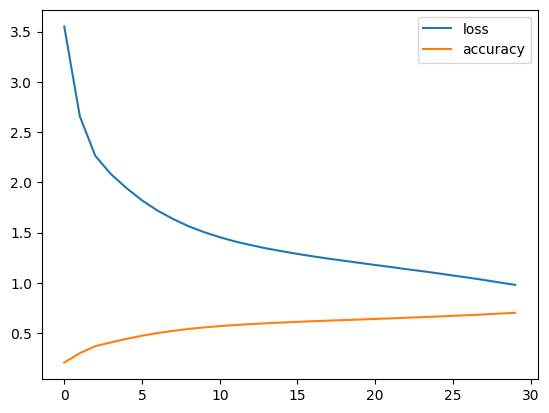

In [86]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [87]:
model.save_weights('./model.h5')

### Generate Text

In [88]:
model = create_model(vocab_size, embed_dim, rnn_neurons, batch_size=1)
model.load_weights('/model.h5')
model.build(tf.TensorShape([1, None]))

In [89]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 64)             5184      
                                                                 
 gru_3 (GRU)                 (1, None, 1024)           3348480   
                                                                 
 dense_3 (Dense)             (1, None, 81)             83025     
                                                                 
Total params: 3436689 (13.11 MB)
Trainable params: 3436689 (13.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
def gen_text(model, start_seed, gen_size=500, temp=1.0):

  input_eval = [char_to_ind[s] for s in start_seed]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []
  model.reset_states()

  num_size = gen_size
  temperature = temp

  for i in range(num_size):

    pred = model(input_eval)
    pred = tf.squeeze(pred, 0)
    pred = pred / temperature
    pred_id = tf.random.categorical(pred, num_samples=1)[-1, 0].numpy()

    input_eval = tf.expand_dims([pred_id], 0)

    text_generated.append(ind_to_char[pred_id])

  return (start_seed + "".join(text_generated))

In [91]:
generated_text = gen_text(model=model, start_seed='JULIET', gen_size=1000)

In [92]:
print(generated_text)

JULIETPATER. Very worthy Marcius!              Enter a Marters and Marcellus.
  Mark.
  Fortie and lived more than to come to spend his manisent to you
  Vear stamp with strife
  Of true eyes withal lossors in thee my slemp,
  Till that my bed, some worth thine, almost all to-night.
  Bet,
  Where all the stherefor I am wrong,
  When a consul that  god made yourself
    Rather robe doth set them- I bring me,
    Speak to the tobbord. Enobarbudu and the

          Enter HALUS and LAPIDUS

  So thou arm not by death, but I must marry me withoutht command,
  And pray bare in solemner out them all.
    But bows and dull the tonet in Caesar. Rome. What is the uneffected words,  
    Which shall do and not chance come to make;
    Mine, mine, nor hote ow's bud or boast,
  Unless no worthless lonages be yee.'LE
    That hath been drum Rome's more than any pronounce to subject for no own; you
  have.
  CLOTEN. In Jumies brave new fear'd, scench else to be fought,
    The knave them wrough I kn